# Setting Up

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
OPEN_API_KEY = os.getenv('OPEN_API_KEY')

LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
LANGSMITH_PROJECT = os.getenv('LANGSMITH_PROJECT')
LANGSMITH_ENDPOINT = os.getenv('LANGSMITH_ENDPOINT')

TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
from tavily import TavilyClient
from pprint import pprint
tavily = TavilyClient(TAVILY_API_KEY)

# Agents:

## Supervisor Agent
- Task: Supervise the research agent and ensure the output is relevant and sufficient to generate a chart.
- Input: A user query
- Process: 
    - Gets the summary and reasoning from the research agent
    - Evaluates the summary and reasoning
    - Decides if the content is relevant and sufficient to generate a chart.
    - If the content is not relevant or sufficient, it will call the research agent again with a new user query.
    - If the content is relevant and sufficient, it will go to the chart_agent to generate a chart with a brief chart description.
- Output:
    - A chart
    - Chart description

## Research Agent
- Task: Research the web for information that is relevant and sufficient to generate a chart.
- Input: A user query
- Process: 
    - Uses tools (web search tool and web scraping tool) to research the web for information
    - Passes the summary and reasoning to the supervisor agent
- Output:
    - A summary of the relevant information extracted from the scraped URLs.
    - Reasoning for the output why the content is relevant and sufficient to generate a chart.


## Chart Agent
- Task: Generate a chart based on the chart summary and provide chart description
- Input: A summary of the relevant information extracted from the scraped URLs.
- Process: 
    - Uses a tool to generate code based on input summary to generate a chart - tool name: code_generator_tool
    - Passes the code to the python repl tool to generate a chart - tool name: python_repl_tool
    - Passes the chart to another tool to generate a chart description - tool name: chart_description_tool
    - Passes both the chart and chart description to the supervisor agent for review
- Output:
    - A Chart
    - A chart description

# 1. Research Agent

Tools to make:
- Web Search Tool (Researcher)
    - Task: Researches the web for information.
    - Input: A user query
    - Process: 
        - Gets the relevant keywords from query to perform a search
        - Uses keyword and performs a search on the web
        - Gets a list of URLs and returns the list (output)
    - Output: A list of URLs

- Web Scraping Tool (Researcher)
    - Task: Scrapes websites from a list of URLs and returns a coherent summary of the content relevant to the user's query.
    - Input: A list of URLs
    - Process: 
        - Iterates over each URL in the provided list of URLs
        - Performs a GET request to the URL
        - Parses the HTML content of the page
        - Combines the scraped content into a coherent summary using a language model (LLM).
    - Output: A string containing a summary of the relevant information extracted from the scraped URLs.

In [5]:
from pydantic import BaseModel, Field

from typing import TypedDict, List
from typing import Annotated
from operator import add
from typing import Literal

class ResearchOutput(BaseModel):
    next_action: Literal["web_search", "web_scraping", "DONE"] = Field(description="The next action to perform. Can be web_search, web_scraping, or DONE if the content is sufficient to generate a chart.")
    reasoning: str = Field(description="Reasoning for the output, explaining which tool should be used next and why the content is relevant and sufficient to generate a chart based on the summary received.")


class AgentState(TypedDict):
    query: str
    actions_performed: Annotated[List[str], add]
    research_agent_output: ResearchOutput
    urls: List[str]
    summary: str
    combined_content: str
    keywords_used: Annotated[List[str], add]

In [6]:
def web_search_tool(state: AgentState):
    """Search the web for information and return URLs"""  

    def extract_keywords(user_query):
        """Extract relevant keywords from a complex user query using LLM"""

        prompt = """
        Extract a unique search term I can use to search the web for numerical data that can be used for chart generation from this query.

        Instructions:
        - The search keywords should be specific and relevant to the query provided.
        - Focus on terms that are likely to yield quantitative data, such as statistics, figures, or metrics.
        - Ensure that the keywords can lead to sources that provide numerical information suitable for creating charts or graphs.
        - The search keywords should consist maximum of 4 words.
        - The generated keywords should be unique and not already included in the existing list of keywords.

        Query: {user_query}
        Keywords used so far: {keywords_used}
        Search term:
        """
        keywords_used = state.get("keywords_used",[""])
        response = llm.invoke(prompt.format(user_query=user_query, keywords_used=keywords_used))
        return response.content

    keywords = extract_keywords(state['query']) 
    print(keywords)
    response = tavily.search(keywords)
    print(response)

    urls = [result['url'] for result in response['results'][:3]]

    return {"urls": urls, "actions_performed": [f"Used the keyword: {keywords} to search the web for information. Received {', '.join(urls)} URLs."], "keywords_used": [keywords]}

In [7]:
#test
# Create a sample state to test the web_scraping_tool function
test_state = AgentState(
    query="What are the latest advancements in AI?",
    urls=[],
    summary="",
    reasoning="",
    combined_content=""
)

# Call the web_scraping_tool function with the test state
urls = web_search_tool(test_state)

# Print the output summary
print(urls)


"AI advancements statistics"
{'query': '"AI advancements statistics"', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [], 'response_time': 1.47}
{'urls': [], 'actions_performed': ['Used the keyword: "AI advancements statistics" to search the web for information. Received  URLs.'], 'keywords_used': ['"AI advancements statistics"']}


In [8]:
from bs4 import BeautifulSoup
import requests

def web_scraping_tool(state: AgentState):
    """Scrape websites from a list of URLs and return a dictionary with URL and content"""
    results = {}
    # Iterate over each URL in the provided list of URLs
    for url in state['urls']:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')
        results[url] = soup.get_text()

    def combine_scraped_content(scraped_data):
        """This function takes a dictionary of scraped data, where each key is a URL and each value is the corresponding content.
        It constructs a prompt for a language model (LLM) to generate a coherent summary of the content relevant to the user's query.
        
        The function initializes a prompt string that instructs the LLM to combine the content. It then iterates over the scraped data,
        appending each URL and its content to the prompt. After constructing the complete prompt, it invokes the LLM with this prompt
        and returns the generated summary as a string."""
        
        prompt = """
        Combine the following content into a coherent summary, relevant for the user query.

        Instructions:
        - If there are any numerical data, make sure to include it in the summary.
        - This numerical data from the summary will be later used to generate a chart.
        """

        for url, content in scraped_data.items():
            prompt += f"URL: {url}\nContent: {content}\n\n"
        
        response = llm.invoke(prompt)
        return response.content

    # Call the combine function and return the combined content
    combined_content = combine_scraped_content(results)
    return {"combined_content": combined_content, "actions_performed": [f"Scraped the content from the URLs: {', '.join(results.keys())} and combined it into a coherent summary."]}

In [9]:
from langchain_core.messages import HumanMessage, SystemMessage

def research_agent(state: AgentState):
    system_prompt = """
    You are an expert researcher. You are given a user query and you need to use tools to research the web for information that is reliable and sufficient to generate a chart.
    
    You need to use the following tools to research the web for information:

    1. Web Search Tool: This tool does the following:
        - Task: Researches the web for information.
        - Input: A user query
        - Process: 
            - Gets the relevant keywords from query to perform a search
            - Uses keyword and performs a search on the web
            - Gets a list of URLs and returns the list (output)
        - Output: A list of URLs
        - Decision: Use this tool ONLY when you need to gather initial information based on the user query OR when the summary from web scraping is insufficient to generate a chart.

    2. Web Scraping Tool: This tool does the following:
        - Task: Scrapes websites from a list of URLs and returns a coherent summary of the content relevant to the user's query.
        - Input: A list of URLs (received from the web_search_tool)
        - Process: 
            - Iterates over each URL in the provided list of URLs
            - Performs a GET request to the URL
            - Parses the HTML content of the page
            - Combines the scraped content into a coherent summary using a language model (LLM).
        - Output: A string containing a summary of the relevant information extracted from the scraped URLs.
        - Decision: Use this tool IMMEDIATELY after receiving URLs from the web search tool to extract relevant content.

    3. If the content is sufficient to generate a chart, you must respond with DONE as the next action and provide reasoning as output.

    Your inputs will be:
    - A user query
    - Actions performed so far
    - A list of URLs obtained from the web_search_tool
    - A summary of the relevant information extracted from the web_scraping_tool. If no URLs have been scraped yet, the summary will be an empty string.

    Your output will be:
    - Next action to perform: Can be web_search, web_scraping, or DONE if the content is sufficient to generate a chart.
    - Reasoning for the output, explaining which tool should be used next and why the content is relevant and sufficient to generate a chart based on the summary received.

    Instructions:
    - You will receive a user query and a summary of the relevant information extracted from the scraped URLs.
    - For your FIRST action, you MUST use the web_search_tool to get a list of URLs based on the user query.
    - After receiving URLs from web_search_tool, you MUST ALWAYS use the web_scraping_tool next to process those URLs.
    - After receiving the summary from web_scraping_tool, evaluate if the content is sufficient to generate a chart.
    - If the summary is sufficient to generate a meaningful chart, respond with DONE.
    - ONLY return to web_search_tool if the summary from web_scraping_tool is inadequate or insufficient for generating a chart.
    - DO NOT repeatedly call web_search_tool if you already have URLs that haven't been scraped yet.

    IMPORTANT: 
    - If this is your first action and no actions have been performed yet, ALWAYS choose web_search_tool.
    - If URLs have been obtained but not yet scraped (check the actions_performed), ALWAYS choose web_scraping_tool next.
    - Only evaluate the sufficiency of information AFTER receiving a summary from web_scraping_tool.
    """
    human_prompt = """
    User Query: {query}
    Actions performed so far: {actions_performed}
    Summary of the relevant information extracted from the scraped URLs: {summary}
    """
    system_message = SystemMessage(content=system_prompt)
    query = state['query']
    actions_performed = state.get('actions_performed', [])
    summary = state.get('combined_content', '')

    human_message = HumanMessage(content=human_prompt.format(query=query, summary=summary, actions_performed=actions_performed))
    

    research_prompt = [system_message, human_message]
    response = llm.with_structured_output(ResearchOutput).invoke(research_prompt)
    return {"research_agent_output": response, "actions_performed": [f"Research agent performed the action: {response.next_action}"]}
    

In [10]:
def end_agent(state: AgentState):
    return state

In [11]:
from langgraph.graph import StateGraph, START, END

def after_research_agent_router(state: AgentState):
    next_action = state['research_agent_output'].next_action
    if next_action == 'web_search':
        return "web_search_tool"
    elif next_action == 'web_scraping':
        return "web_scraping_tool"
    elif next_action == 'DONE':
        return "end_agent"
    

### Graph 1: Research Agent

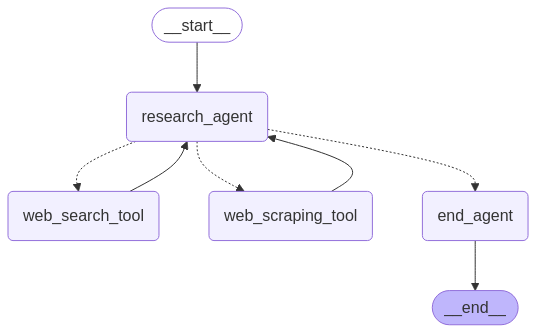

In [12]:
from IPython.display import Image, display

graph = StateGraph(AgentState)
graph.add_node("research_agent", research_agent)
graph.add_node("web_search_tool", web_search_tool)
graph.add_node("web_scraping_tool", web_scraping_tool)
graph.add_node("end_agent", end_agent)

graph.add_edge(START, "research_agent")
graph.add_conditional_edges(
    "research_agent",
    after_research_agent_router,
    ["web_search_tool", "web_scraping_tool", "end_agent"]
)
graph.add_edge("web_search_tool", "research_agent")
graph.add_edge("web_scraping_tool", "research_agent")
graph.add_edge("end_agent", END)
research_agent = graph.compile()

display(Image(research_agent.get_graph().draw_mermaid_png()))


In [13]:
for event in research_agent.stream({"query": "What is the current stock price trends of Apple"}):
    print(event)

{'research_agent': {'research_agent_output': ResearchOutput(next_action='web_search', reasoning='Since this is the first action and no actions have been performed yet, I will use the web_search_tool to gather a list of URLs that provide information on the current stock price trends of Apple. This will help in obtaining the necessary data to generate a chart on the stock price trends.')}}
Apple stock price trends
{'query': 'Apple stock price trends', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Apple - 45 Year Stock Price History | AAPL | MacroTrends', 'url': 'https://www.macrotrends.net/stocks/charts/AAPL/apple/stock-price-history', 'content': 'Apple - 45 Year Stock Price History | AAPL | MacroTrends Apple - 45 Year Stock Price History | AAPL The latest closing stock price for Apple as of March 06, 2025 is 235.33. The all-time high Apple stock closing price was 259.02 on December 26, 2024. The Apple 52-week high stock price is 260.10, which is 10.5%

# 2. Chart Agent

In [14]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL
import matplotlib as plt

In [15]:
def python_repl_tool(code):
    """Execute Python code and return the output"""
    python_repl = PythonREPL()
    result = python_repl.run(code)
    return result

#test

code = """
import matplotlib.pyplot as plt

# Data for plotting
x = [0, 1, 2, 3, 4, 5]
y = [0, 1, 4, 9, 16, 25]

# Create the plot
plt.plot(x, y, marker='o', linestyle='-', color='b', label='y = x^2')

# Add title and labels
plt.title('Simple Line Chart')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display legend
plt.legend()

# Show the plot
plt.show()
 """

python_repl_tool(print("Hello, world!"))

Python REPL can execute arbitrary code. Use with caution.


Hello, world!


'TypeError("expected string or bytes-like object, got \'NoneType\'")'